Sentiment Analysis for 'Amazon Mobile Unlocked' dataset.
*   Importing the required library's
*   Cleaning the data
*   Tokenizing the text
*   Converting the text to integer sequence
*   Building the model
*   Making predictions
*   Calculating score , classification report 








In [154]:
import os
import pandas as pd
from tensorflow.keras.layers import Embedding
from tensorflow.keras.models import Sequential
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer
import re
from tensorflow.keras import layers as L
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model
import nltk
import tensorflow as tf
from tqdm import tqdm

from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
os.chdir("/content/drive/My Drive/Python/Practice/Amazon mobile")

In [131]:
ls

'Amazon mobile.ipynb'   Amazon_Unlocked_Mobile.csv


In [132]:
data = pd.read_csv("Amazon_Unlocked_Mobile.csv")

In [133]:
data.head()

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes
0,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,I feel so LUCKY to have found this used (phone...,1.0
1,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,"nice phone, nice up grade from my pantach revu...",0.0
2,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,Very pleased,0.0
3,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,It works good but it goes slow sometimes but i...,0.0
4,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,Great phone to replace my lost phone. The only...,0.0


Since we are dealing a highly imbalanced dataset populated with mainly positive reviews , we will balance the dataset with equal number of reviews on both the classes

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


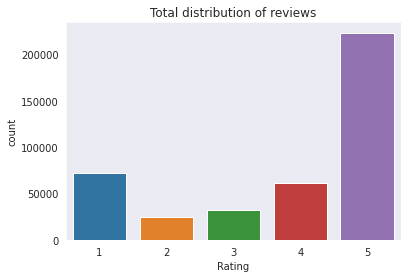

In [134]:
plt.title("Total distribution of reviews")
sns.set_style("dark")
sns.countplot(data['Rating'])

Making this a binary classification problem

In [135]:
def process_review(review): 
  return 1 if review>=3 else 0 

In [136]:
new_df = data[['Rating','Reviews']]

In [137]:
new_df = new_df.sample(frac=1).reset_index(drop=True)

In [138]:
new_df.head()

,Rating,Reviews
0,5,A lot cheaper same quality
1,5,My husband loves this phone! He has not had on...
2,2,I like how it looks but for browsing is a prob...
3,5,best phone i've ever had
4,5,super super nice phone


In [139]:
new_df['new_rating'] = new_df['Rating'].apply(process_review)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


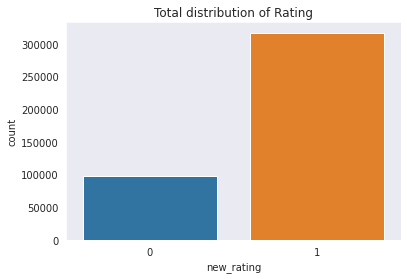

In [140]:
plt.title("Total distribution of Rating")
sns.countplot(new_df['new_rating'])

In [141]:
new_df.drop(['Rating'],axis=1,inplace=True)

In [142]:
new_df['new_rating'].value_counts()

1    316762
0     97078
Name: new_rating, dtype: int64

<h2>Balancing the dataset</h2>


In [143]:
positive_reviews = new_df.loc[new_df['new_rating']==1][:60000]
negative_reviews = new_df.loc[new_df['new_rating']==0][:60000]

In [144]:
final_df = pd.concat([positive_reviews,negative_reviews])

In [146]:
final_df.head()

,Reviews,new_rating
0,A lot cheaper same quality,1
1,My husband loves this phone! He has not had on...,1
3,best phone i've ever had,1
4,super super nice phone,1
5,Phone is just what I expected and in good cond...,1


In [147]:
final_df['new_rating'].value_counts()

1    60000
0    60000
Name: new_rating, dtype: int64

In [148]:
final_df = final_df.sample(frac=1).reset_index(drop=True)

<h2>Cleaning the dataset</h2>

In [27]:
def process_text(text):
  new_text = str(text)
  new_text = new_text.lower()
  new_text = re.sub("[^a-zA-Z]"," ",new_text)
  new_text = new_text.split(" ")
  new_text = " ".join([word for word in new_text if word not in stopwords.words("english")])
  return new_text

In [16]:
tqdm.pandas()

In [151]:
final_df['final_review'] = final_df['Reviews'].progress_apply(process_text)

100%|██████████| 120000/120000 [10:48<00:00, 185.12it/s]


<h2>Tokenizing & Converting to sequence</h2>

In [ ]:
reviews = final_df['final_review'].values
sentiment = final_df['new_rating'].values

In [155]:
tokenizer = Tokenizer()

In [156]:
tokenizer.fit_on_texts(reviews)

In [156]:
print(f"Total number of words : { len(tokenizer.index_word)+1}")

Total number of words : 38239


In [159]:
sequence_text = tokenizer.texts_to_sequences(reviews)

In [160]:
sequence_text = pad_sequences(sequence_text , padding='post')

<h2>Building the model</h2>

In [161]:
x_train , x_test , y_train ,y_test = train_test_split(sequence_text,sentiment,
                                                      test_size=0.2,random_state=11)

In [162]:
print(f"""
X Train :{x_train.shape}
X TEST : {x_test.shape}
Y TRAIN : {y_train.shape}
Y TEST  : {y_test.shape}
""")


X Train :(96000, 1557)
X TEST : (24000, 1557)
Y TRAIN : (96000,)
Y TEST  : (24000,)



In [163]:
VOCAB_SIZE = len(tokenizer.word_index)+1
EMBEDDING_VEC = 30

In [177]:
model = tf.keras.Sequential([
L.Embedding(VOCAB_SIZE,EMBEDDING_VEC, input_length=x_train.shape[1]),
L.Bidirectional(L.LSTM(128,return_sequences=True)),
L.GlobalMaxPool1D(),
L.Dropout(0.4),
L.Dense(128, activation="relu"),
L.Dropout(0.4),
L.Dense(2)
])
model.compile(loss=SparseCategoricalCrossentropy(from_logits=True),
          optimizer='adam',metrics=['accuracy']
          )

In [178]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 1557, 30)          1147170   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 1557, 256)         162816    
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 256)               0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 2)                

In [181]:
model.fit(x_train,y_train , validation_data=(x_test,y_test),batch_size=32
          ,epochs=2)

Epoch 1/2
3000/3000 [==============================] - 8487s 3s/step - loss: 0.2883 - accuracy: 0.8821 - val_loss: 0.2431 - val_accuracy: 0.9072
Epoch 2/2
3000/3000 [==============================] - 8504s 3s/step - loss: 0.2137 - accuracy: 0.9210 - val_loss: 0.2252 - val_accuracy: 0.9139


In [182]:
model.save("weights.h5")

<h2>Prediction on Test data</h2>
Predicting on the remaining unseen data

In [183]:
validation_positive_reviews = new_df.loc[new_df['new_rating']==1][60000:]
validation_negative_reviews = new_df.loc[new_df['new_rating']==0][60000:]

In [184]:
validation_data = pd.concat([validation_positive_reviews,validation_negative_reviews])

In [24]:
validation_data.head()

,Reviews,new_rating
0,great phone,1
1,I was excited to have gotten this phone in spr...,1
2,Thank you!,1
3,EXCELENTE,1
4,Simple and straight forward. Easy to use. Grea...,1


In [151]:
validation_data['new_rating'].value_counts()

1    256762
0     37078
Name: new_rating, dtype: int64

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


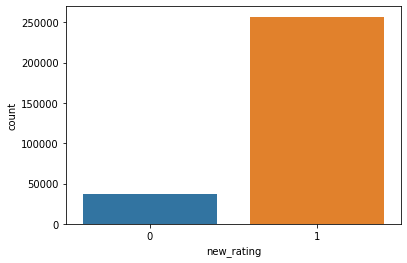

In [150]:
sns.countplot(validation_data['new_rating'])

In [25]:
y_valid = validation_data['new_rating'].values

In [84]:
validation_data['Reviews'] = validation_data['Reviews'].apply(process_text)

In [118]:
validation_review = validation_data['Reviews'].values

In [127]:
sequence = tokenizer.texts_to_sequences(validation_review)

In [128]:
sequence = pad_sequences(sequence,padding="post")

In [136]:
predict = model.predict_classes(sequence)

<h2>Model prediction report</h2>

In [147]:
print(f"The accuracy is : {accuracy_score(y_valid,predict)*100}%")

The accuracy is : 91.66553226245576%


In [145]:
print(confusion_matrix(y_valid,predict))

[[ 33762   3316]
 [ 21174 235588]]


In [155]:
print (classification_report(y_valid,predict))

              precision    recall  f1-score   support

           0       0.61      0.91      0.73     37078
           1       0.99      0.92      0.95    256762

    accuracy                           0.92    293840
   macro avg       0.80      0.91      0.84    293840
weighted avg       0.94      0.92      0.92    293840

